In this notebook, I will learn how to run some basic edge detection algorithms from Julia. Given an image, return an edge map. To do this, I want to learn how to do the following:

1. Run a Sobel kernel on an input image
2. Create an edge map using the high frequency signal from the image
3. Have a long aside about array notation in Julia

This is a natural follow-up to my [blurring computation from a previous exercise](http://learningjulia.com/2017/02/24/blurring-and-manipulation.html), since the Sobel operator is just a different kind of kernel. But it is also a common kernel needed in image manipulation, so I can compare my implemenation timing to the implementation in the [ImageFiltering.jl](https://github.com/JuliaImages/ImageFiltering.jl) package. After timing the built-in functions, I won't even try to time my own implemenation...

## Setup

First things first, let's set up for manipulating images.

In [1]:
using Images, FileIO, Colors;

The test image is going to be of our former president, Barack Obama.

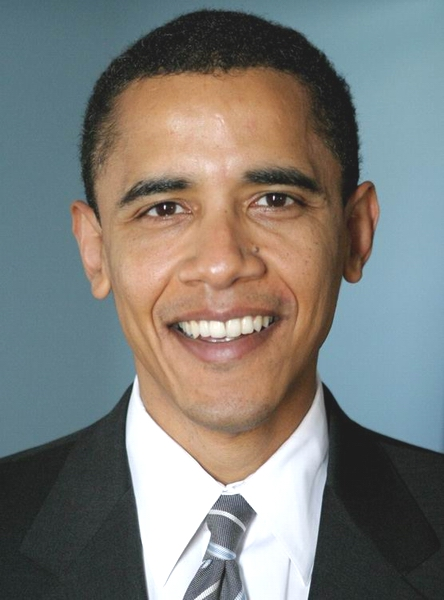

In [12]:
img = load("obama.jpg")

The Sobel kernel should operate on grayscale images, and we can use operator broadcasting to do that:

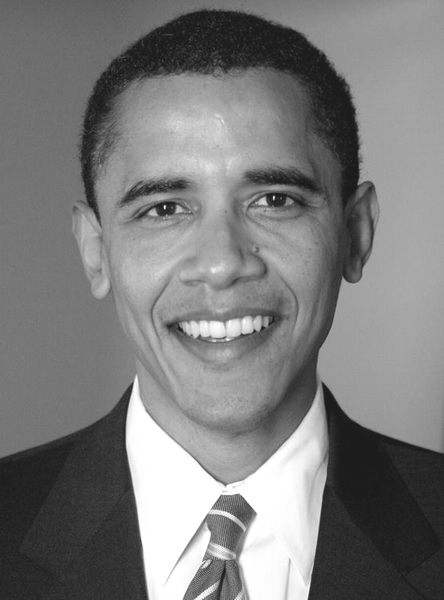

In [51]:
img_gray = Gray.(img)

## Sobel kernels

The first thing we'll try doing is manually running a Sobel image kernel on the input image. The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is basically an approximation of derivatives in the `X` and `Y` directions of the image. The theory is that if there is a high gradient magnitude, there is an edge in that location. The way you compute the Sobel operator is to convolve this kernel:

$$K_x = \begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$

in the `X` direction, and 

$$K_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

in the `Y` direction. Note how they are just transposes of each other.

Practically, to compute the kernel, we need to iterate over the output image. As we discussed in [a previous post](http://learningjulia.com/2017/02/24/blurring-and-manipulation.html), when transforming one image into another, you need to iterate over the output image, and for each pixel, find the pixels from the input image needed to compute that particular pixel. In the case of the Sobel kernel, we need to iterate over the output twice - once for the `X` direction, which needs 9 pixels for the computation, and once for the `Y` direction computation, which also needs 9 pixels.

## The `imfilter` function

To apply image kernels, I am going to use the `imfilter` function from JuliaImages: http://juliaimages.github.io/latest/function_reference.html#ImageFiltering.imfilter. Rather than manually trying to implement out-of-bounds implementations or worrying about applying a dot product / convolution, let's just use the builtins.

Another awesome feature of the JuliaImages library is the ability to pad the input according to 4 rules:

1. _replicate_ - repeat the edge value until infinity
2. _circular_ - image edges "wrap around"
3. _symmetric_ - reflect relative to the required position
4. _reflect_ - reflect relative to the edge

Read more here: http://juliaimages.github.io/latest/function_reference.html#Boundaries-and-padding-1. Which you can specify by doing something like:

```
    imfilter(img, kernel, "replicate")
```

In my case, I will just use the "replicate" mode.

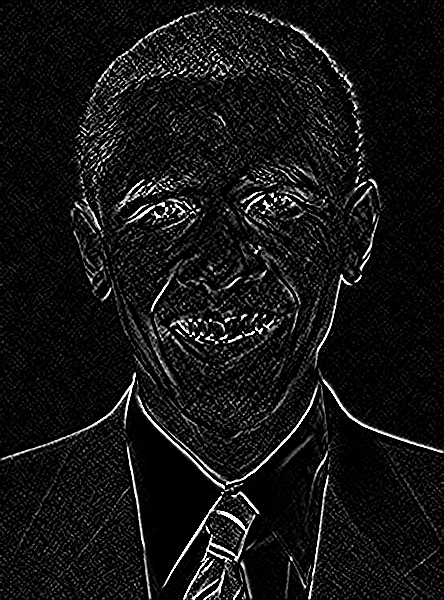

In [141]:
kernel = [1 0 -1; 2 0 -2;1 0 -1];
sobel_x = imfilter(img_gray, kernel);
grad = imfilter(sobel_x, kernel')

There are a few things to note about the `imfilter` function:

1. It doesn't do _convolution_. Instead, it does _correlation_. The difference is basically that in _convolution_ the kernel is flipped, so if you want to do convolution with `imfilter`, you should do `reflect()` around your kernel.
2. You need to assign a "center" to the kernels. Normally when we think of kernels we think of the center as being the central number in the kernel - in the Sobel kernels above the center is (1, 1). To do this in Julia, the default calling of `imfilter` will do this, or you can explicitly instantiate the a kernel by calling `centered()`:

    ```
    kernel = centered([1 0 -1; 2 0 -2;1 0 -1]);
    imfilter(img_gray, kernel)
    ```

    But in case you want a different center, you can use the [OffsetArrays](https://github.com/alsam/OffsetArrays.jl) package.
    
## Sobel to edges

What you can see from the image after the Sobel kernel is applied in the x and y directions is that there is a lot of noise all over the image - this is because the kernel is only looking at neighborhoods of 3x3. To get around this, we can just take the magnitude of the gradient, or even the 4th power of the gradient.

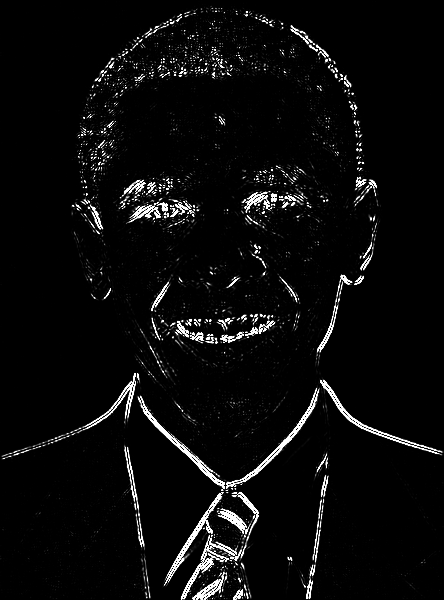

In [142]:
grad .^ 4

As you can see, much less noise.

## Separable kernels

However, using some interesting properties of the Sobel convolution operation, we can do even better. The Sobel kernel is separable - we can compute the full 3x3 kernel as a multiplication of a 1x3 and 3x1 kernels.

The kernels above ($K_x$ and $K_y$) can each be factored into two 1-dimensional kernels:

$$K_x = \begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix} = \begin{bmatrix}1 \\ 2 \\ 1 \end{bmatrix} \cdot \begin{bmatrix}1 & 0 & -1 \end{bmatrix}$$

$$K_y = \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} = \begin{bmatrix}1 \\ 0 \\ -1 \end{bmatrix} \cdot \begin{bmatrix}1 & 2 & 1 \end{bmatrix}$$

So we can pass these 4 smaller kernels into `imfilter()` to get the same result:

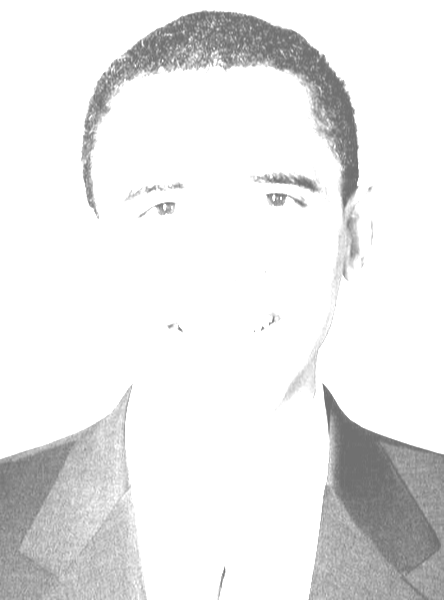

In [165]:
kernel_1 = [1 2 1]';
kernel_2 = [1 0 -1];
grad_sep = imfilter(img_gray, (kernel_1, kernel_2, kernel_2', kernel_1'))

Note the only difference is that the boundaries of the image are pure black. This is probably because of the kernel size - the kernel that is `3x1` needs only pixels horizontally, not vertically, so the "replication" step of the `imfilter` code replicates the default value, which is black.

## Factoring Kernels

We can do even one better than manually factorizong kernels. We can use a feature built into the `imfilter` library to automatically factor the kernel itself before calling the `imfilter` function. You can see a detailed example of how to use it here: http://juliaimages.github.io/latest/imagefiltering.html#Factored-kernels-1.

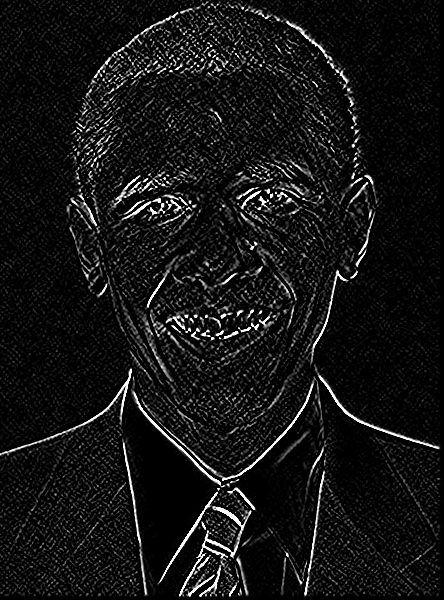

In [138]:
grad_auto_factoring = imfilter(img_gray, kernelfactors((kernel, kernel')))

In fact, the `imfilter()` function implementation automatically tries to factorize the kernels when it is called: https://github.com/JuliaImages/ImageFiltering.jl/blob/master/src/imfilter.jl#L10, so you don't have to remember to get this functionality for free.

There is one more way to apply Sobel kernels to the image. Of course, `imfilter()` has a Sobel kernel built in. and it's even automatically separable. The difference as you can see with the built-in `sobel` kernel is that it is normalized - the kernel is divided by the sum of the kernel (which in this case is 8), so the sum of all the factors in the kernel is equal to 1. This is a common technique in computer vision and image processing, but for visualizing the results here, we will multiply the output by 64 to get the same output image as above (8 for each kernel, and there are 2 kernels in the sobel kernel).

In [87]:
Kernel.sobel()

(
[-0.125 -0.25 -0.125; 0.0 0.0 0.0; 0.125 0.25 0.125],

[-0.125 0.0 0.125; -0.25 0.0 0.25; -0.125 0.0 0.125])

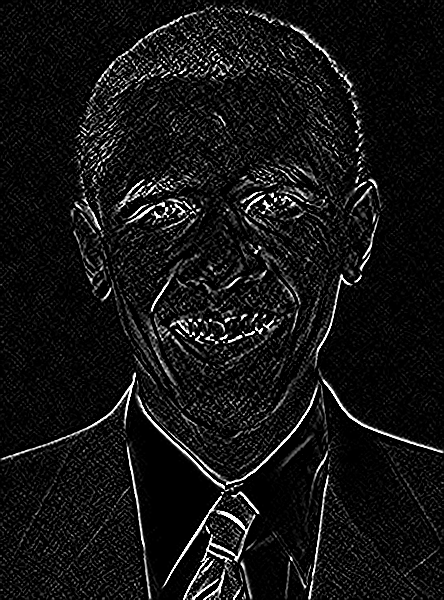

In [149]:
grad_builtin_sobel = 64 * imfilter(img_gray, Kernel.sobel())

## The notable lack of OpenCV

When I first started out on this learning, I thought [Opencv.jl](https://github.com/JuliaOpenCV/OpenCV.jl) would have a wrapper around all the functions available in the [OpenCV library](http://opencv.org/). However, the Opencv.jl library is not mature, and is only a manual wrapper around functions available in Opencv. The Sobel kernel is not one of the available functions, so I didn't get a chance to test it! Notably, one of the issues in the Opencv.jl package is to automatically wrap all the Opencv functions: https://github.com/JuliaOpenCV/OpenCV.jl/issues/7. I can't wait!

## Timings

Now let's compare the timings of all the methods. The Julia documentation talks about timing code regularly with the `@time` macro, and using that to guide development: http://docs.julialang.org/en/stable/manual/performance-tips/#measure-performance-with-time-and-pay-attention-to-memory-allocation. The most important thing to note about the `@time` macro is that first time it is called will also time all the compilation time needed for any code that is being timed AND code that actually will be timed. So to get an accurate reading, you should call `@time` twice. It also tells you how much memory is allocated.

Sometimes the output of `@time` will say something like `40.71% gc time` - this means that 40% of the time is spent garbage-collecting unused variables and freeing memory. So you can either ignore those runs or ignore that amount of time in your final analysis.

We want to time all these runs:

1. Manually calling `imfilter` with the full kernel
2. Manually calling `imfilter` with the manually-factored kernel
3. Calling `imfilter` with an explicit call to `kernelfactor`

In [162]:
# scenario 1
for i in 1:5
    @time imfilter(img_gray, (kernel, kernel'));
end

  0.023770 seconds (188 allocations: 2.087 MB)
  0.020832 seconds (188 allocations: 2.087 MB)
  0.018937 seconds (188 allocations: 2.087 MB)
  0.017686 seconds (188 allocations: 2.087 MB)
  0.016757 seconds (188 allocations: 2.087 MB)


In [163]:
# scenario 2
for i in 1:5
    @time imfilter(img_gray, (kernel_1, kernel_2, kernel_2', kernel_1'));
end

  0.032206 seconds (1.63 k allocations: 2.164 MB)
  0.014009 seconds (1.63 k allocations: 2.164 MB)
  0.662528 seconds (1.63 k allocations: 2.164 MB, 96.71% gc time)
  0.023312 seconds (1.63 k allocations: 2.164 MB)
  0.039780 seconds (1.63 k allocations: 2.164 MB)


In [164]:
# scenario 3
for i in 1:5
    @time 64 * imfilter(img_gray, Kernel.sobel())
end

  0.013234 seconds (304 allocations: 6.164 MB)
  0.014551 seconds (304 allocations: 6.164 MB)
  0.011798 seconds (304 allocations: 6.164 MB, 23.15% gc time)
  0.008135 seconds (304 allocations: 6.164 MB)
  0.008432 seconds (304 allocations: 6.164 MB)


Based on the timing results, we can see that manually trying to factor yields the _WORST_ results! Julia does a lot of the heavy lifting behind-the-scenes with function inlining and compiling. For the kernel that is built-in, like the Sobel kernel (https://github.com/JuliaImages/ImageFiltering.jl/blob/master/src/kernelfactors.jl#L151), you can actually see that the factors are hand-coded, so it will naturally be faster.

But you never know if this will be true in general! So from what I can tell, the `@time` macro is critical for development.

## Wrapping up with gradients

I originally intended this exploration to be USING the image gradient rather than all about computing it, but instead it turned into an explanation of `@time` and a divergence into array notation (see below), so next time I will actually use the image gradient to do some fun image manipulation!

## An aside on array notation

The major learning from this post was actually about how array notation works in Julia. When I was first trying to get the kernel factoring calls working, I was having a problem with a particular error:

In [167]:
imfilter(img_gray, ([1;2;1]))

LoadError: ArgumentError: ImageFiltering.Pad{1}(:replicate,(1,),(1,)) lacks the proper padding sizes for an array with 2 dimensions

Contrast to this:

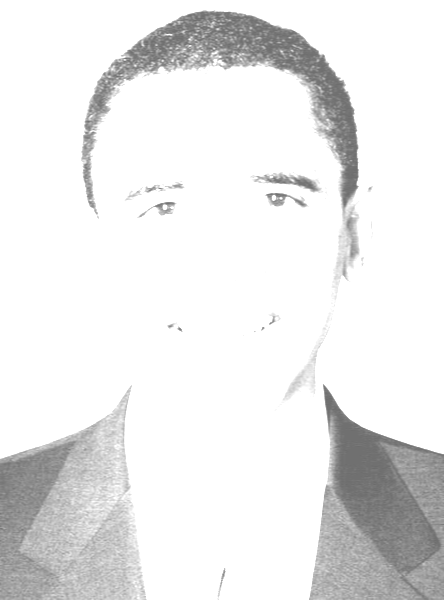

In [169]:
imfilter(img_gray, ([1 2 1]))

I couldn't figure out what was happening. But what I realized was that the actual type that was returned when the kernel array was created was different. Take a look:

In [170]:
[1 2 3]

1×3 Array{Int64,2}:
 1  2  3

In [171]:
[1; 2; 3;]

3-element Array{Int64,1}:
 1
 2
 3

In [172]:
[[1 2 3]; [4 5 6]]

2×3 Array{Int64,2}:
 1  2  3
 4  5  6

My original thought was that `;` means "new row" and space means "new column", but I was wrong. Actually, the distinction is between vertical and horizontal concatenation. So while `[1 2 3]` gives me a `1x3` array, I expected `[1; 2; 3;]` to give me a `3x1` array, but it doesn't - it returns a 3-element array instead. To get a `3x1` array I need to do `[1 2 3]'`:

In [173]:
[1 2 3]'

3×1 Array{Int64,2}:
 1
 2
 3

I actually thought this was inconsistent and filed an issue on the Julia issue tracker: https://github.com/JuliaLang/julia/issues/20957. But it turns out I was obviously not the first one to notice this or report it. In fact, there is a whole thread on the [Julia Discourse forums](http://discourse.julialang.org) that I am now following: https://discourse.julialang.org/t/whats-the-meaning-of-the-array-syntax/938, and would be interested in learning how it gets fixed. I will be following this issue closely as the language evolves!

I think consistency would go a long way to making newbies not confused with new syntax. In any case, I learned something new.